<a href="https://colab.research.google.com/github/PtrShi/cvr_course/blob/main/notebooks/cv_hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание 3

1) [1 балл] Реализуйте чтение изображений, лежащих в /data/imgs/arrow (как в демо с калибровкой камеры с семинара). Вся обязательная часть задания выполняется с этими изображениями

1) [2 балла] Реализуйте нахождение расстояния от камеры до листка, учитывая, что это тот же листок, что был в первом демо

2) [3 балла] Реализуйте приведение изображения листка к "виду сверху"

3) [6 баллов] Реализуйте определение направления, в котором указывает стрелка. Можно использовать скелетонизацию из первого семинара по зрению: получить маску темной области (стрелки) внутри изображения листка, применить скелетонизацию, вычислить направление. Можно поступить иначе: после нахождения маски вычислить градиенты Собеля по x и y и проанализировать их направления. P.S. Можно использовать и полностью свой метод

4) [3 балла] Доп. задача 1: Примените написанный Вами код к видео https://drive.google.com/file/d/1AQhg2lL5FL4edlOcxY2SHOOZ-v9TgHBD/view?usp=sharing. Загрузите видео на свой гугл диск, а затем дополните имеющийся код монтированием диска и чтением в цикле кадров видео, приведёнными в конце семинара

5) [5 баллов] Доп. задача 2: определите, нормально ли видно листок в кадре. На некоторых кадрах его видно не полностью, один или больше уголков находятся за кадром. Это можно автоматически обнаруживать, к примеру используя размеры стрелки, и выводить на соответствующем кадре маркер - текст или цветную метку

In [4]:
!git clone https://github.com/PtrShi/cvr_course.git
#%cd "cvr_course/notebooks"
#!ls

fatal: destination path 'cvr_course' already exists and is not an empty directory.


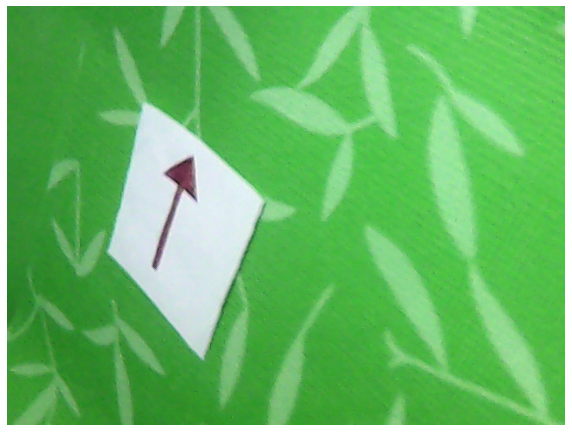

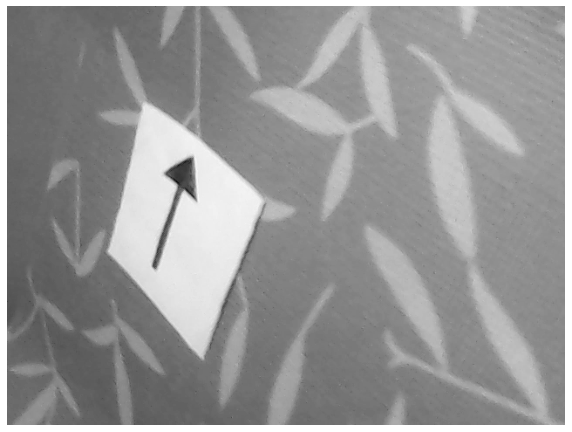

In [5]:
import numpy as np
import cv2
import time
import os
import math
import sys
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)
imgdir = 'cvr_course/data/imgs/arrow/'
filename = 'vlcsnap-2020-10-21-18h01m22s212.png'
#filename = 'vlcsnap-2020-10-21-18h01m51s638.png'
img_orig = cv2.imread (imgdir + filename, cv2.IMREAD_COLOR)
if img_orig is None:
  assert False, 'no such a file'
plt.imshow (img_orig)  
plt.axis ('off')
plt.show ()
img_bw = cv2.cvtColor (img_orig, cv2.COLOR_BGR2GRAY)
plt.imshow (img_bw, cmap = 'gray')
plt.axis ('off')
plt.show ()

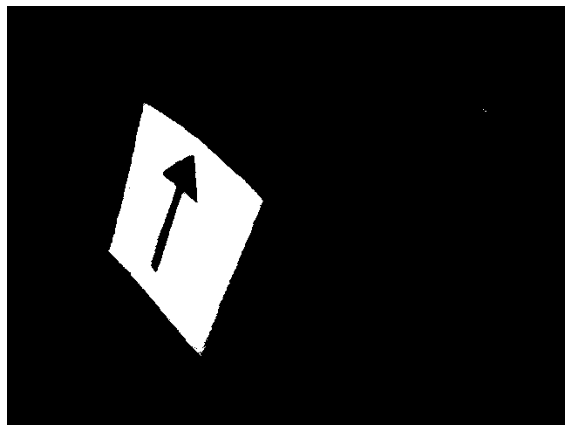

In [6]:
# Mask
low_th  = (210) #, 200, 200)  # Надо менять в зависимости от картинки
high_th = (255) #, 255, 255)

mask = cv2.inRange (img_bw, low_th, high_th)
# ker_sz = 3
# kernel = np.ones ((ker_sz, ker_sz), np.uint8)
# mask = cv2.dilate (mask, kernel, iterations = 1)  

plt.imshow (mask, cmap = 'gray')
plt.axis ('off')
plt.show ()

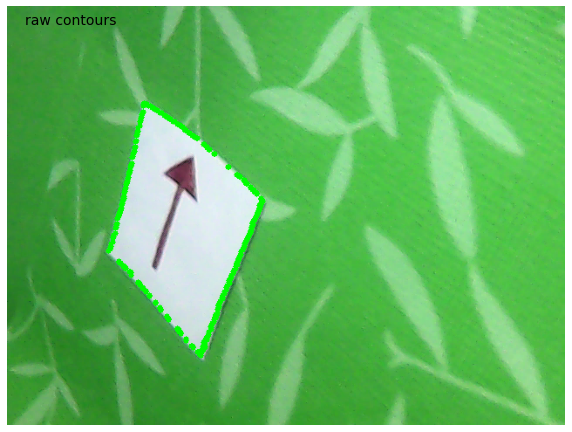

(343, 1, 2)
(17, 1, 2)


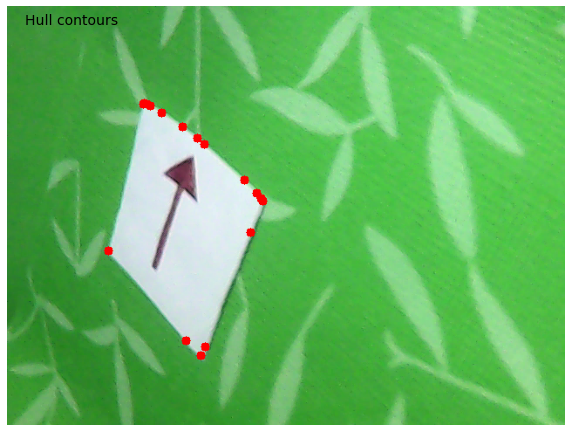

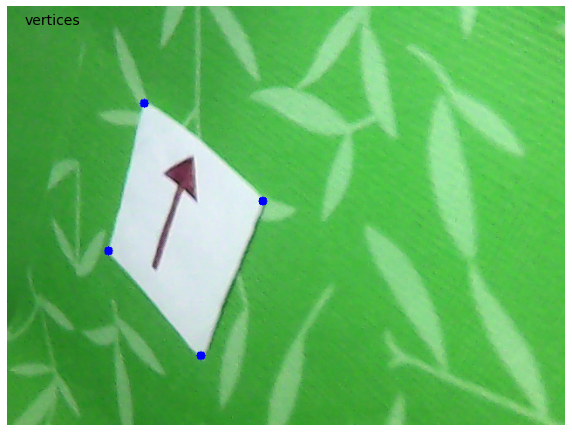

In [27]:
# ищем контуры
contours, _ = cv2.findContours (mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
j = 1 
ind_largest_cont = 0 # let's find the largest contour
# I'm not so good with python magic
while j < len (contours):
  if len (contours [j]) > len (contours [ind_largest_cont]):
    ind_largest_cont = j
  j = j + 1

cnt = contours [ind_largest_cont]

cnt_raw = cv2.drawContours (img_orig.copy (), cnt, -1, (0, 255, 0), 5)
plt.imshow (cnt_raw)
plt.text (20, 20, 'raw contours', fontsize=14)
plt.axis ('off')
plt.show ()

print (np.shape (cnt))
cnt_hull = cv2.convexHull (cnt)
cnt_hull_draw = cv2.drawContours (img_orig.copy (), cnt_hull, -1, (255, 0, 0), 10)
print (np.shape (cnt_hull))
plt.imshow (cnt_hull_draw)
plt.text (20, 20, 'Hull contours', fontsize=14)
plt.axis ('off')
plt.show ()

epsilon = 0.05 * cv2.arcLength (cnt_hull, True)
vertices = cv2.approxPolyDP (cnt_hull, epsilon, True)
vertices_draw = cv2.drawContours (img_orig.copy (), vertices, -1, (0, 0, 255), 10)
plt.imshow (vertices_draw)
plt.text (20, 20, 'vertices', fontsize=14)
plt.axis ('off')
plt.show ()

In [17]:
def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype="float32")
    
    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis=1)
    print (s)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis=1)
    print (diff)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    # return the ordered coordinates
    return rect

In [18]:
vertices_norm = vertices [:,0,:]
print (vertices_norm)
rect = order_points (vertices_norm)
print (rect)

[[157 111]
 [293 223]
 [222 400]
 [116 280]]
[268 516 622 396]
[[-46]
 [-70]
 [178]
 [164]]
[[157. 111.]
 [293. 223.]
 [222. 400.]
 [222. 400.]]
